# Classificação de Sentimentos com Modelos Supervisionados

In [ ]:
#### 📘 Contexto do Problema

O problema em questão trata-se de **classificação de textos**. A tarefa consiste em analisar um conjunto de **resenhas de livros** e prever se a resenha é **positiva ou negativa**, baseado no conteúdo textual dessas resenhas.

Este tipo de problema é típico em **sistemas de recomendação**, como os utilizados por plataformas como **Amazon, Goodreads ou Google Play Books**, que precisam identificar automaticamente a satisfação do cliente com base em suas avaliações.

O objetivo do modelo é atribuir uma **classe (positiva ou negativa)** a cada resenha, usando o **conteúdo textual** como único atributo. A modelagem deste problema envolve o uso de técnicas de **Processamento de Linguagem Natural (PLN)**, como a transformação do texto em uma forma compreensível por algoritmos de aprendizado de máquina. Para isso, utilizamos vetores de palavras e abordagens como **TF-IDF (Term Frequency - Inverse Document Frequency)** para extrair as características mais relevantes de cada resenha.

O sucesso deste tipo de tarefa tem **aplicações amplas**, desde a **filtragem de conteúdo** até a **recomendação personalizada** e a **análise de sentimentos**, onde a **precisão do modelo** é importante para garantir a fidelidade das análises geradas a partir das resenhas dos usuários.

---

#### 📚 Descrição do Conjunto de Dados: *Amazon Polarity*

O conjunto de dados **Amazon Polarity** é uma coleção de **resenhas de produtos extraídas da Amazon**, com o objetivo de realizar **análise de sentimentos**.

Cada resenha foi classificada como **positiva ou negativa**, com base na opinião expressa pelo usuário:

- `0` → Resenha **negativa**
- `1` → Resenha **positiva**

Este conjunto de dados é amplamente utilizado em tarefas de **classificação de sentimentos** e **análise de texto**, ideal para treinar e testar modelos de aprendizado de máquina com o propósito de **identificar automaticamente a polaridade** de novas resenhas.

---

#### 📌 Características do Conjunto de Dados

- **🔢 Tamanho:**  
  Contém **milhares de resenhas** rotuladas como positivas (1) ou negativas (0).

- **📝 Texto da Resenha:**  
  Cada amostra é composta por um **texto livre**, escrito por um usuário da Amazon. Os textos variam bastante em **tamanho e conteúdo**, abrangendo produtos como **eletrônicos, roupas, acessórios, livros** e muito mais.

- **👍👎 Polaridade:**  
  O modelo deve prever a **opinião (positiva ou negativa)** com base no texto.

---

#### 🛠️ Aplicações

- **🔍 Análise de Sentimentos:**  
  Classificação automática das opiniões dos consumidores, sem leitura manual.

- **🤖 Sistemas de Recomendação:**  
  Avaliações ajudam a ajustar algoritmos de recomendação em e-commerces.

- **📈 Análise de Feedback:**  
  Permite obter insights sobre a **satisfação do cliente** e **melhorias de produto**.

---

#### 🤖 Modelos Utilizados

Os modelos foram treinados para prever a **classe da resenha (positiva ou negativa)**. Os seguintes algoritmos foram avaliados:

- 🔹 **Regressão Logística**
- 🔹 **Máquina de Vetores de Suporte (SVM)**
- 🔹 **XGBoost**
- 🔹 **Random Forest**

---

#### 📊 Avaliação dos Resultados

Os resultados de cada modelo foram avaliados com as seguintes métricas:

- **Acurácia**
- **Precisão**
- **Recall**
- **F1-Score**
- **Curva ROC / AUC**

Essas métricas foram usadas para garantir uma **avaliação equilibrada** do desempenho dos modelos, considerando não apenas a taxa de acertos, mas também a performance em prever corretamente **ambas as classes**.

## Imports

In [32]:
# Manipulação de dados
import pandas as pd
import numpy as np

# Pré-processamento
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

# Modelos
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC

# Avaliação
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc

# Visualização
import matplotlib.pyplot as plt
from datasets import load_dataset

#NLP
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/jonnathann/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/jonnathann/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/jonnathann/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## Leitura dataset geral

In [7]:
dataset = load_dataset("amazon_polarity")

### Gerando Dataframe

In [ ]:
df = pd.DataFrame(dataset["train"])
df['label'].value_counts()

### Pegando uma amostra de dados menor para essa análise e salvando

In [10]:
df_balanced = pd.concat([
    df[df['label'] == 0].sample(n=5000, random_state=42),
    df[df['label'] == 1].sample(n=5000, random_state=42)
])

df_balanced = df_balanced.sample(n=10000, random_state=42)
df_balanced.to_csv('../data/processed/sample_amazon_polarity.csv', index=False)

### Lendo a amostra de dados em um novo DataFrame

In [17]:
df_samples = pd.read_csv('../data/processed/sample_amazon_polarity.csv')
df_samples.head()

,label,title,content
0,1,Road to getting things done,I am a great believer in valueing employees an...
1,0,The Weight Loss Cure,This would be a good book. Good Ideas if every...
2,0,Royal Velvet Pillows,These pillows were over rated and the descript...
3,0,Great Book For Kiddies,Robert Sawyer's books have featured an assortm...
4,0,Digimortal,"You know, Fear Factory used to be my favorite ..."


In [18]:
df_samples['label'].value_counts()

label
1    5000
0    5000
Name: count, dtype: int64

### Verificando dimensões das classes

In [19]:
df_samples.shape
df_samples.label.unique()

array([1, 0])

## Análise Exploratória e Limpeza dos Dados

### Aplicando limpeza dos dados

In [22]:
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = re.sub(r'http\S+|www\S+|@\S+', '', text)
    text = re.sub(r'[^A-Za-z\s]', '', text)
    text = text.lower()
    words = nltk.word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]
    words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(words)

In [23]:
df_samples['cleaned_title'] = df_samples['title'].apply(clean_text)
df_samples['cleaned_content'] = df_samples['content'].apply(clean_text)

### Concatenando cleaned_title e cleaned_content

In [25]:
df_samples['title_content'] = df_samples['cleaned_title'] + ' ' + df_samples['cleaned_content']
df_samples.head()

,label,title,content,cleaned_title,cleaned_content,title_content
0,1,Road to getting things done,I am a great believer in valueing employees an...,road getting thing done,great believer valueing employee rewarding pro...,road getting thing done great believer valuein...
1,0,The Weight Loss Cure,This would be a good book. Good Ideas if every...,weight loss cure,would good book good idea everyone needed lose...,weight loss cure would good book good idea eve...
2,0,Royal Velvet Pillows,These pillows were over rated and the descript...,royal velvet pillow,pillow rated description amamzon accuratewe di...,royal velvet pillow pillow rated description a...
3,0,Great Book For Kiddies,Robert Sawyer's books have featured an assortm...,great book kiddy,robert sawyer book featured assortment funny e...,great book kiddy robert sawyer book featured a...
4,0,Digimortal,"You know, Fear Factory used to be my favorite ...",digimortal,know fear factory used favorite band album rea...,digimortal know fear factory used favorite ban...


## Pré-Processamento

### Vetorização com TF-IDF

In [27]:
tfidf = TfidfVectorizer(max_features=1000)
X = tfidf.fit_transform(df_samples['title_content'])

X_df = pd.DataFrame(X.toarray(), columns=tfidf.get_feature_names_out())
X_df.head()

,able,absolutely,account,accurate,across,act,acting,action,actor,actual,...,written,wrong,wrote,year,yes,yet,youll,young,youre,youve
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.337877,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.129794,0.0


### Separação Treino/Teste

In [28]:
y = df_samples['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Modelos de classificação

### Regressão Logística

Acurácia: 0.836
              precision    recall  f1-score   support

           0       0.83      0.85      0.84      1013
           1       0.84      0.83      0.83       987

    accuracy                           0.84      2000
   macro avg       0.84      0.84      0.84      2000
weighted avg       0.84      0.84      0.84      2000



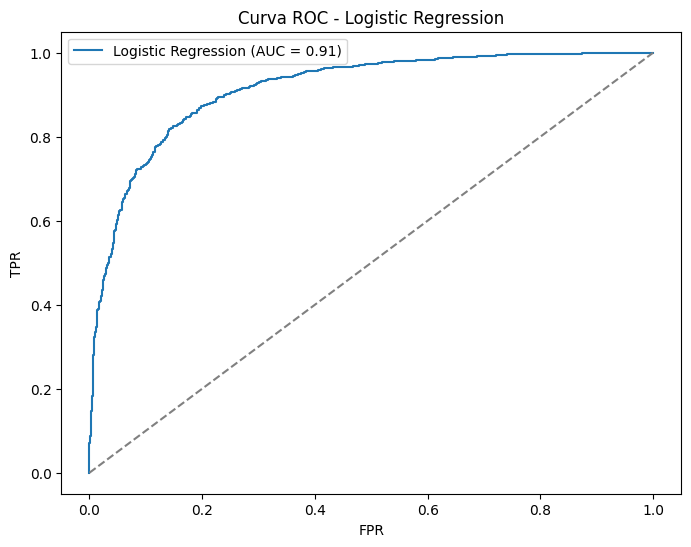

In [29]:
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

print(f'Acurácia: {accuracy_score(y_test, y_pred)}')
print(classification_report(y_test, y_pred))

fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Logistic Regression (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('Curva ROC - Logistic Regression')
plt.legend()
plt.show()

### Support Vector Machine (SVM)

Acurácia: 0.83
              precision    recall  f1-score   support

           0       0.82      0.85      0.84      1013
           1       0.84      0.81      0.82       987

    accuracy                           0.83      2000
   macro avg       0.83      0.83      0.83      2000
weighted avg       0.83      0.83      0.83      2000



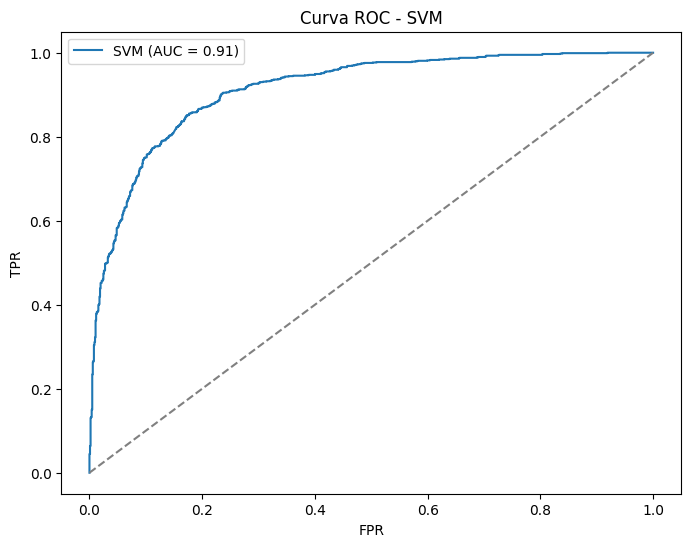

In [31]:
svm = SVC(random_state=42, probability=True)
svm.fit(X_train, y_train)

y_pred = svm.predict(X_test)
y_prob = svm.predict_proba(X_test)[:, 1]

print(f'Acurácia: {accuracy_score(y_test, y_pred)}')
print(classification_report(y_test, y_pred))

fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'SVM (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('Curva ROC - SVM')
plt.legend()
plt.show()

### XGBoost

Acurácia: 0.811
              precision    recall  f1-score   support

           0       0.81      0.82      0.81      1013
           1       0.81      0.80      0.81       987

    accuracy                           0.81      2000
   macro avg       0.81      0.81      0.81      2000
weighted avg       0.81      0.81      0.81      2000



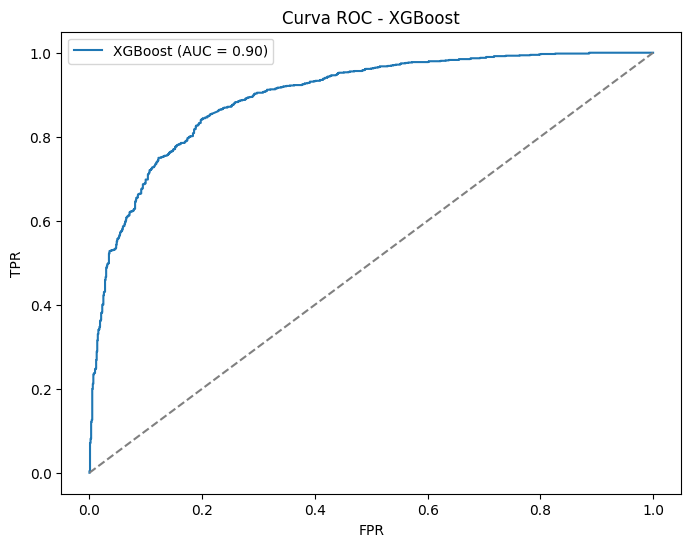

In [36]:
xgb = XGBClassifier(eval_metric='logloss', random_state=42)
xgb.fit(X_train, y_train)

y_pred = xgb.predict(X_test)
y_prob = xgb.predict_proba(X_test)[:, 1]

print(f'Acurácia: {accuracy_score(y_test, y_pred)}')
print(classification_report(y_test, y_pred))

fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'XGBoost (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('Curva ROC - XGBoost')
plt.legend()
plt.show()

Acurácia: 0.811
              precision    recall  f1-score   support

           0       0.82      0.81      0.81      1013
           1       0.80      0.82      0.81       987

    accuracy                           0.81      2000
   macro avg       0.81      0.81      0.81      2000
weighted avg       0.81      0.81      0.81      2000



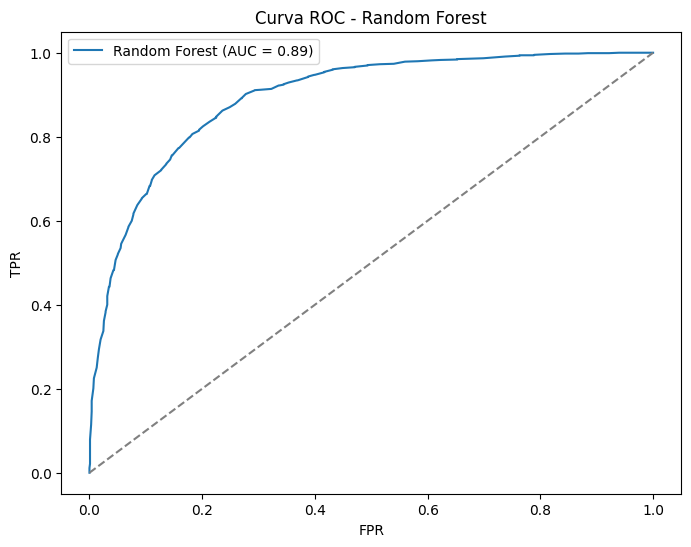

In [37]:
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
y_prob = rf.predict_proba(X_test)[:, 1]

print(f'Acurácia: {accuracy_score(y_test, y_pred)}')
print(classification_report(y_test, y_pred))

fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Random Forest (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('Curva ROC - Random Forest')
plt.legend()
plt.show()

### 📊 Resultados dos Modelos

#### 📈 Regressão Logística  
- 🔹 **AUC:** 0.91  
- 🎯 **Acurácia:** 0.811  
- 🧪 Classe 0: Precisão = 0.81 | Recall = 0.82 | F1-score = 0.81 | Amostras = 1013  
- 🧪 Classe 1: Precisão = 0.81 | Recall = 0.80 | F1-score = 0.81 | Amostras = 987  
- 📦 Total de amostras: 2000

---

#### 🤖 SVM (Máquina de Vetores de Suporte)  
- 🔹 **AUC:** 0.91  
- 🎯 **Acurácia:** 0.83  
- 🧪 Classe 0: Precisão = 0.82 | Recall = 0.85 | F1-score = 0.84 | Amostras = 1013  
- 🧪 Classe 1: Precisão = 0.84 | Recall = 0.81 | F1-score = 0.82 | Amostras = 987  
- 📦 Total de amostras: 2000

---

#### ⚡ XGBoost  
- 🔹 **AUC:** 0.90  
- 🎯 **Acurácia:** 0.83  
- 🧪 Classe 0: Precisão = 0.82 | Recall = 0.85 | F1-score = 0.84 | Amostras = 1013  
- 🧪 Classe 1: Precisão = 0.84 | Recall = 0.81 | F1-score = 0.82 | Amostras = 987  
- 📦 Total de amostras: 2000

---

#### 🌲 Random Forest  
- 🔹 **AUC:** 0.89  
- 🎯 **Acurácia:** 0.811  
- 🧪 Classe 0: Precisão = 0.82 | Recall = 0.81 | F1-score = 0.81 | Amostras = 1013  
- 🧪 Classe 1: Precisão = 0.80 | Recall = 0.82 | F1-score = 0.81 | Amostras = 987  
- 📦 Total de amostras: 2000

## Análise de Sentimentos com NLP

#### Descrição do Conjunto de Dados: Amazon Polarity
O conjunto de dados Amazon Polarity é uma coleção de resenhas de produtos extraídas de comentários de usuários na Amazon, com o objetivo de realizar a análise de sentimentos. O conjunto contém textos de resenhas que foram classificados como positivos ou negativos com base na opinião expressa pelo usuário. Cada resenha está rotulada com um valor binário: 0 para resenhas negativas e 1 para resenhas positivas.

O conjunto de dados é um recurso muito utilizado em tarefas de classificação de sentimentos e análise de texto, e é ideal para treinar e testar modelos de aprendizado de máquina que buscam identificar automaticamente se uma opinião expressa em uma resenha é favorável ou desfavorável. Com isso, o modelo pode ser utilizado para prever a polaridade de novos comentários ou resenhas.

#### Características do Conjunto de Dados:
##### Tamanho: O conjunto de dados é composto por milhares de resenhas, com rótulos binários indicando se a resenha é positiva (1) ou negativa (0).

##### Texto da Resenha: Cada amostra contém um texto de resenha escrito por um usuário da Amazon. O conteúdo dessas resenhas varia muito em termos de comprimento e tópicos, pois os produtos abrangem uma ampla gama de categorias, como eletrônicos, roupas, acessórios, livros, e muito mais.

##### Polaridade: A principal característica é a polaridade da resenha, onde o modelo precisa prever se a opinião do usuário é positiva ou negativa com base no conteúdo da resenha.

##### Aplicações:
Análise de Sentimentos: O principal objetivo desse conjunto de dados é classificar as opiniões dos consumidores de maneira automática, sem necessidade de leitura manual de cada resenha.
Sistemas de Recomendação: Compreender a opinião dos consumidores sobre determinados produtos pode ser usado para ajustar e melhorar sistemas de recomendação em plataformas de e-commerce.
Análise de Feedback: A análise automática das resenhas pode proporcionar insights valiosos para empresas, permitindo-lhes entender melhor a satisfação do cliente e identificar áreas de melhoria nos produtos.

Os modelos utilizados nesse estudo foram então treinados para prever a classe da resenha, e os seguintes algoritmos foram avaliados no conjunto de dados:

##### Regressão Logística

##### Máquina de Vetores de Suporte (SVM)

##### XGBoost

##### Random Forest

Os resultados de cada modelo foram avaliados com métricas como acurácia, precisão, recall e f1-score e curva AUC para garantir uma análise mais equilibrada, considerando não apenas a taxa de acertos, mas também a performance do modelo nas classes positivas e negativas.

#### Resultados
Neste trabalho, foi realizada uma análise de sentimentos em resenhas de produtos da Amazon, utilizando diferentes modelos de machine learning para prever a polaridade das avaliações (positiva ou negativa). Para isso, utilizamos quatro algoritmos principais: Regressão Logística, SVM (Máquina de Vetores de Suporte), XGBoost e Random Forest, comparando suas performances por meio de métricas de avaliação como Acurácia, Precision, Recall, F1-Score e AUC (Área sob a Curva ROC).

Resultados dos Modelos

##### Regressão Logística:

Acurácia: 0.836

AUC: 0.91

A Regressão Logística obteve o melhor desempenho em termos de Acurácia entre os modelos avaliados. Embora tenha apresentado uma AUC de 0.91 (similar ao SVM), sua capacidade de fazer previsões corretas foi ligeiramente superior, atingindo 83.6% de acerto.

##### SVM (Máquina de Vetores de Suporte):

Acurácia: 0.

AUC: 0.91

O SVM apresentou a melhor AUC, com 0.91, indicando uma excelente capacidade de discriminação entre as classes. No entanto, sua Acurácia foi um pouco inferior à da Regressão Logística, com 83%. Mesmo assim, o SVM demonstrou bom desempenho em termos de Precision e Recall, sendo uma escolha robusta para este tipo de problema.

##### XGBoost:

Acurácia: 0.8165

AUC: 0.90

O modelo XGBoost teve uma Acurácia de 81.65%, ligeiramente inferior à da Regressão Logística. A AUC também foi de 0.90, indicando que o modelo tem um bom poder de discriminação entre as classes, embora não tenha superado o SVM em AUC.

##### Random Forest:

Acurácia: 0.8105

AUC: 0.90

A Random Forest teve uma Acurácia de 81.05%, ficando abaixo da Regressão Logística. No entanto, a AUC também foi de 0.90, indicando que a capacidade de distinguir entre as classes foi razoavelmente boa. O desempenho da Random Forest foi sólido, mas não foi capaz de superar os outros modelos em termos de acurácia ou AUC.

#### Conclusões
Com base nos resultados obtidos, com os parâmetros escolhidos, podemos observar que:

O modelo de Regressão Logística apresentou o melhor desempenho geral em termos de acurácia, atingindo 83.6%, seguido pelo SVM, que teve a melhor AUC (0.91) e uma boa precisão e recall.
O SVM mostrou-se bastante eficaz em termos de discriminação entre as classes, mas teve uma leve perda em Acurácia comparado à Regressão Logística.

O XGBoost e a Random Forest também apresentaram resultados bastante sólidos, com Acurácias ao redor de 81% e boas AUCs de 0.90, mas não foram tão eficazes quanto os outros dois modelos.